In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format ='retina'

In [51]:
import tensorflow as tf
import numpy as np
from scipy.stats import pearsonr, spearmanr
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    gpu_num = 1
    try:
        tf.config.experimental.set_visible_devices(gpus[gpu_num], 'GPU')
        #tf.config.experimental.set_memory_growth(gpus[gpu_num], True)
        tf.config.experimental.set_virtual_device_configuration(
            gpus[gpu_num],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4000)])
    except RuntimeError as e:
        print(e)

In [4]:
from data_import_preprocessing import import_data_preprocessing
from model_define import CNNLSTM_model

In [5]:
train_data_name = 'data/HT_Cas9_train.csv'
test_data_name = 'data/HT_Cas9_test.csv'
preprocessing = import_data_preprocessing(train_data_file_name = train_data_name,
                                          test_data_file_name= test_data_name,
                                         )
print('train_data : ', preprocessing.train_data_file_sample_column)
print('train_data : ', preprocessing.test_data_file_sample_column)

train_data :  ['Barcode', 'Target context sequence', 'Total read count (Day 0)', 'Indel read count\n(Day 0)', 'Background\nindel frequencies (%)', 'Total read count\n(Day 2.9)', 'Indel read count\n(Day 2.9)', 'Indel frequencies (%)', 'Background subtracted indel']
train_data :  ['Target context sequence', 'Number of used (filtered ) barcodes', 'Total read count (average, Day 0)', 'Total read count (average, Day 2.9)', 'Background subtracted indel']


In [6]:
data = preprocessing(sgRNA_column='Target context sequence',
                    indel_column='Background subtracted indel',
                    split_data=0.1
                    )
print(data.keys())
print(data['train'].keys())

dict_keys(['train', 'val', 'total', 'test'])
dict_keys(['seq', 'indel_rate', 'indel_class', 'read_cnt', 'info'])


In [7]:
X_train = data['train']['seq']
class_train = data['train']['indel_class']
rate_train = data['train']['indel_rate']

X_val = data['val']['seq']
class_val = data['val']['indel_class']
rate_val = data['val']['indel_rate']

X_test = data['test']['seq']
class_test = data['test']['indel_class']
rate_test = data['test']['indel_rate']

input_shape = X_train.shape[1:]

In [8]:
CNNLSTM = CNNLSTM_model(input_shape=input_shape)

In [9]:
CNNLSTM_model = CNNLSTM.MTL_model()
CNNLSTM_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 30, 4)]      0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 30, 16)       80          input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 30, 16)       144         input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 30, 16)       208         input_1[0][0]                    
______________________________________________________________________________________________

In [10]:
CNNLSTM_model.compile(optimizer='adam',
              loss={
                  #'num_mis': 'categorical_crossentropy',
                  'class_1': 'categorical_crossentropy',
                  'class_2': 'categorical_crossentropy',
                  'class_final': 'categorical_crossentropy',
                  'rate': 'mean_squared_error'},
              loss_weights={
                  #'num_mis': 0.5,
                  'class_1': 1,
                  'class_2': 1,
                  'class_final': 0.5,
                  'rate': 1},
              metrics={
                  #'num_mis': 'accuracy',
                  'class_1': "accuracy",
                  'class_2': "accuracy",
                  'class_final': "accuracy"}
             )

In [11]:
from sklearn.utils import class_weight
class_train_num = class_train.argmax(axis=-1)
class_weights = class_weight.compute_class_weight('balanced',
                                                  np.unique(class_train_num),
                                                  class_train_num
                                                 )
class_weights_dict = dict(enumerate(class_weights))#{ i : class_weights[i] for i in range(11)}
print("class_weight")
print(class_weights_dict)

class_wieghts_dict_tuned = class_weights_dict
for i in range(0,11):
    multiple_constant = 2
    cutoff_class = 5
    
    if i <=cutoff_class:
        class_wieghts_dict_tuned[i] = 1.0
    else:
        class_wieghts_dict_tuned[i] = multiple_constant*np.tanh((class_weights_dict[i]-2)/2) + multiple_constant
    
print("sample_weight")
print(class_wieghts_dict_tuned)

sample_weight = np.array([class_wieghts_dict_tuned[i] for i in class_train_num])

class_weight
{0: 1.171672077922078, 1: 0.9026811537559603, 2: 0.7846174752004348, 3: 0.7098162148872088, 4: 0.6924922043655553, 5: 0.635098718583292, 6: 0.6500422178440755, 7: 0.8690547862733293, 8: 1.841786283891547, 9: 9.631359466221852, 10: 1049.8181818181818}
sample_weight
{0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 0.8235090959499638, 7: 0.975946828981805, 8: 1.8421154881397088, 9: 3.998060936178457, 10: 4.0}


In [12]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  min_delta=0.0005,
                                                  patience=50, verbose=0, mode='auto')

CNNLSTM_model.fit(x=X_train,
              y={
                  #'num_mis': num_mis_train,
                  'class_1': class_train,
                  'class_2': class_train,
                  'class_final': class_train,
                  'rate': rate_train},
              validation_data=(X_val, {#'num_mis': num_mis_val,
                                       'class_1': class_val,
                                       'class_2': class_val,
                                       'class_final': class_val,
                                       'rate': rate_val}),
              class_weight={
                  'class_1' : class_weights_dict,
                  'class_2' : class_weights_dict,
                  'class_final' : class_weights_dict},
              #sample_weight={'rate' : sample_weight},
              shuffle=True,
              epochs=200,
              batch_size=128,
              verbose=1,
              callbacks=[early_stopping]
             )

Train on 11548 samples, validate on 1284 samples
Epoch 1/200
11548/11548 [==============================] - 17s 1ms/sample - loss: 6.1898 - class_1_loss: 2.4380 - class_2_loss: 2.4387 - class_final_loss: 2.4550 - rate_loss: 0.0855 - class_1_accuracy: 0.1233 - class_2_accuracy: 0.1263 - class_final_accuracy: 0.1282 - val_loss: 6.1021 - val_class_1_loss: 2.4379 - val_class_2_loss: 2.4381 - val_class_final_loss: 2.4713 - val_rate_loss: 0.0737 - val_class_1_accuracy: 0.1410 - val_class_2_accuracy: 0.1449 - val_class_final_accuracy: 0.1410
Epoch 2/200
11548/11548 [==============================] - 5s 443us/sample - loss: 5.9895 - class_1_loss: 2.3573 - class_2_loss: 2.3686 - class_final_loss: 2.3939 - rate_loss: 0.0637 - class_1_accuracy: 0.1492 - class_2_accuracy: 0.1470 - class_final_accuracy: 0.1383 - val_loss: 5.8103 - val_class_1_loss: 2.3252 - val_class_2_loss: 2.3402 - val_class_final_loss: 2.3934 - val_rate_loss: 0.0713 - val_class_1_accuracy: 0.1667 - val_class_2_accuracy: 0.1869 -

11548/11548 [==============================] - 5s 465us/sample - loss: 4.9701 - class_1_loss: 1.9721 - class_2_loss: 1.9777 - class_final_loss: 1.9797 - rate_loss: 0.0309 - class_1_accuracy: 0.2469 - class_2_accuracy: 0.2430 - class_final_accuracy: 0.2387 - val_loss: 4.8888 - val_class_1_loss: 2.0082 - val_class_2_loss: 2.0118 - val_class_final_loss: 2.0052 - val_rate_loss: 0.0284 - val_class_1_accuracy: 0.2640 - val_class_2_accuracy: 0.2523 - val_class_final_accuracy: 0.2492
Epoch 18/200
11548/11548 [==============================] - 5s 462us/sample - loss: 4.9709 - class_1_loss: 1.9738 - class_2_loss: 1.9755 - class_final_loss: 1.9802 - rate_loss: 0.0307 - class_1_accuracy: 0.2393 - class_2_accuracy: 0.2443 - class_final_accuracy: 0.2376 - val_loss: 4.8696 - val_class_1_loss: 1.9943 - val_class_2_loss: 1.9975 - val_class_final_loss: 1.9836 - val_rate_loss: 0.0277 - val_class_1_accuracy: 0.2375 - val_class_2_accuracy: 0.2368 - val_class_final_accuracy: 0.2383
Epoch 19/200
11548/11548 

Epoch 34/200
11548/11548 [==============================] - 5s 471us/sample - loss: 4.7766 - class_1_loss: 1.9001 - class_2_loss: 1.8922 - class_final_loss: 1.9068 - rate_loss: 0.0279 - class_1_accuracy: 0.2625 - class_2_accuracy: 0.2664 - class_final_accuracy: 0.2624 - val_loss: 4.7859 - val_class_1_loss: 1.9731 - val_class_2_loss: 1.9787 - val_class_final_loss: 1.9789 - val_rate_loss: 0.0262 - val_class_1_accuracy: 0.2765 - val_class_2_accuracy: 0.2687 - val_class_final_accuracy: 0.2702
Epoch 35/200
11548/11548 [==============================] - 5s 470us/sample - loss: 4.7615 - class_1_loss: 1.8960 - class_2_loss: 1.8939 - class_final_loss: 1.8951 - rate_loss: 0.0278 - class_1_accuracy: 0.2616 - class_2_accuracy: 0.2575 - class_final_accuracy: 0.2626 - val_loss: 4.8578 - val_class_1_loss: 2.0356 - val_class_2_loss: 2.0382 - val_class_final_loss: 2.0286 - val_rate_loss: 0.0284 - val_class_1_accuracy: 0.2570 - val_class_2_accuracy: 0.2523 - val_class_final_accuracy: 0.2531
Epoch 36/200

Epoch 51/200
11548/11548 [==============================] - 5s 474us/sample - loss: 4.6107 - class_1_loss: 1.8301 - class_2_loss: 1.8322 - class_final_loss: 1.8379 - rate_loss: 0.0257 - class_1_accuracy: 0.2702 - class_2_accuracy: 0.2747 - class_final_accuracy: 0.2725 - val_loss: 4.8901 - val_class_1_loss: 2.0599 - val_class_2_loss: 2.0664 - val_class_final_loss: 2.0342 - val_rate_loss: 0.0262 - val_class_1_accuracy: 0.2453 - val_class_2_accuracy: 0.2438 - val_class_final_accuracy: 0.2484
Epoch 52/200
11548/11548 [==============================] - 5s 472us/sample - loss: 4.5894 - class_1_loss: 1.8213 - class_2_loss: 1.8290 - class_final_loss: 1.8277 - rate_loss: 0.0254 - class_1_accuracy: 0.2758 - class_2_accuracy: 0.2740 - class_final_accuracy: 0.2723 - val_loss: 4.9836 - val_class_1_loss: 2.0589 - val_class_2_loss: 2.0554 - val_class_final_loss: 2.0468 - val_rate_loss: 0.0270 - val_class_1_accuracy: 0.2484 - val_class_2_accuracy: 0.2399 - val_class_final_accuracy: 0.2321
Epoch 53/200

Epoch 68/200
11548/11548 [==============================] - 5s 472us/sample - loss: 4.4341 - class_1_loss: 1.7549 - class_2_loss: 1.7607 - class_final_loss: 1.7739 - rate_loss: 0.0241 - class_1_accuracy: 0.2926 - class_2_accuracy: 0.2874 - class_final_accuracy: 0.2939 - val_loss: 5.1836 - val_class_1_loss: 2.1975 - val_class_2_loss: 2.1805 - val_class_final_loss: 2.1424 - val_rate_loss: 0.0265 - val_class_1_accuracy: 0.2492 - val_class_2_accuracy: 0.2500 - val_class_final_accuracy: 0.2484
Epoch 69/200
11548/11548 [==============================] - 5s 476us/sample - loss: 4.3885 - class_1_loss: 1.7476 - class_2_loss: 1.7432 - class_final_loss: 1.7495 - rate_loss: 0.0235 - class_1_accuracy: 0.2888 - class_2_accuracy: 0.2986 - class_final_accuracy: 0.2949 - val_loss: 5.0743 - val_class_1_loss: 2.1299 - val_class_2_loss: 2.1453 - val_class_final_loss: 2.0947 - val_rate_loss: 0.0261 - val_class_1_accuracy: 0.2484 - val_class_2_accuracy: 0.2430 - val_class_final_accuracy: 0.2477
Epoch 70/200

In [13]:
test_prediction = CNNLSTM.regression_model().predict(X_test)
test_prediction = np.array(test_prediction).reshape(-1,)
test_true = rate_test.reshape(-1,)

test_correlation = np.corrcoef(test_prediction, test_true).flatten()[1]
pearson_corr = pearsonr(test_prediction, test_true)
spearman_corr = spearmanr(test_prediction, test_true)
print('Correlation : {}'.format(test_correlation))
print('Pearson Correlation : {}'.format(pearson_corr[0]))
print('Spearman Correlation : {}'.format(spearman_corr[0]))

Correlation : 0.731419235021694
Pearson Correlation : 0.731419235021694
Spearman Correlation : 0.7239095391700755


In [14]:
class_result_acc = CNNLSTM_model.evaluate(X_test,
                                      {
                                          #'num_mis': num_mis_test,
                                          'class_1': class_test,
                                          'class_2': class_test,
                                          'class_final': class_test,
                                          'rate': rate_test},
                                      verbose=0
                                     )
#print(MTL_model.metrics_names)
#print(class_result_acc)
result_label = CNNLSTM_model.metrics_names
for label, result in zip(result_label, class_result_acc):
    print('{:16} : {:>6.4f}'.format(label,result))

loss             : 4.4796
class_1_loss     : 1.7792
class_2_loss     : 1.7846
class_final_loss : 1.7904
rate_loss        : 0.0210
class_1_accuracy : 0.2694
class_2_accuracy : 0.2417
class_final_accuracy : 0.2491


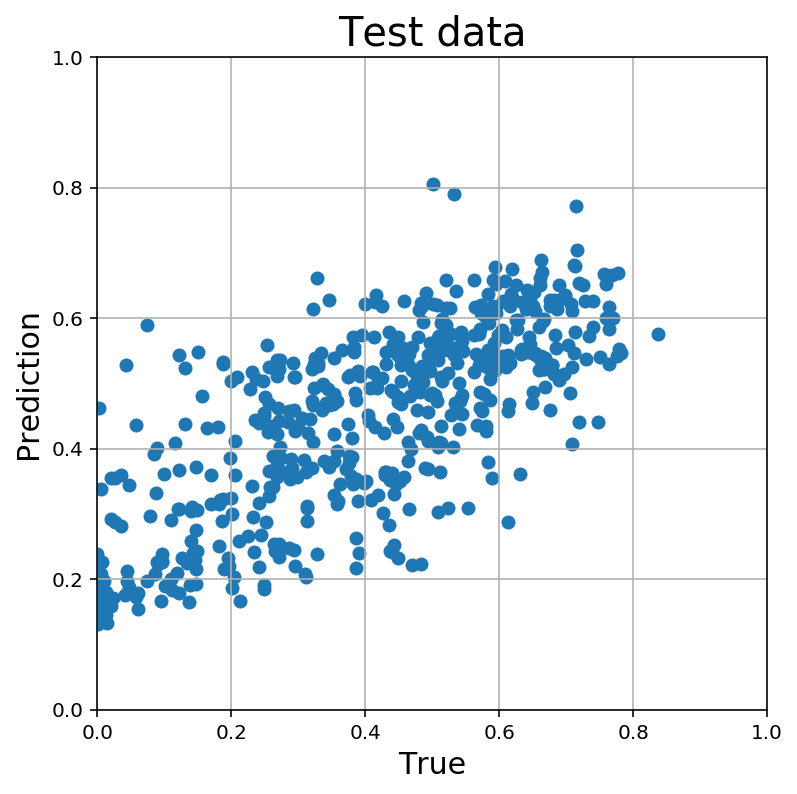

In [15]:
indel_predict = test_prediction
indel_true = test_true

fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(x=indel_true, y=indel_predict)
ax.set_title('Test data', fontsize=20)
ax.set_xlabel('True', fontsize=15)
ax.set_ylabel('Prediction', fontsize=15)
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.grid(True)
fig.show()

In [16]:
train_prediction = CNNLSTM.regression_model().predict(X_train).reshape(-1,)
train_true = rate_train.reshape(-1,)

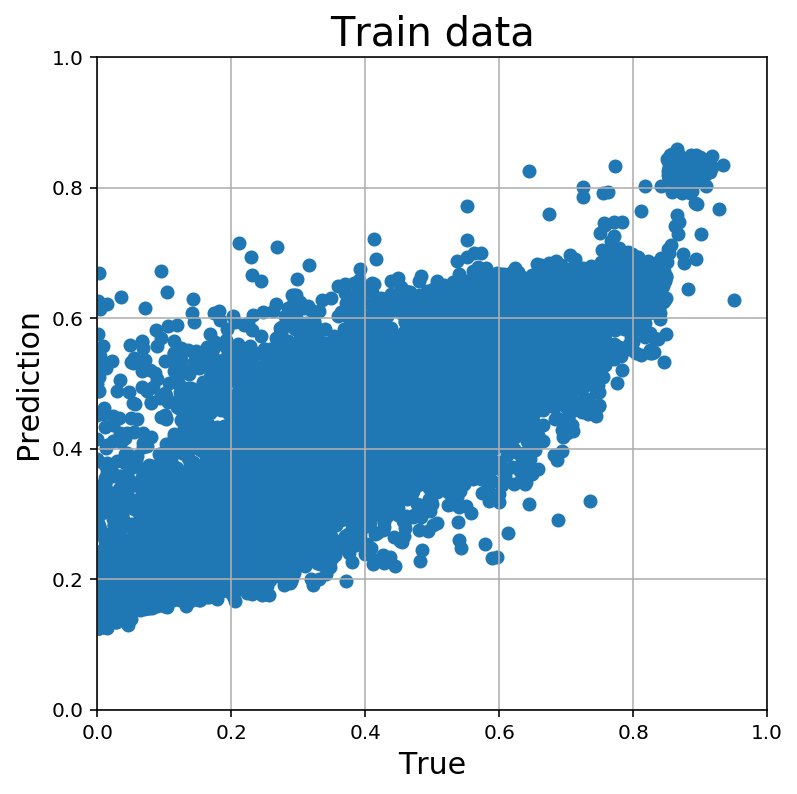

In [17]:
indel_predict = train_prediction
indel_true = train_true

fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(x=indel_true, y=indel_predict)
ax.set_title('Train data', fontsize=20)
ax.set_xlabel('True', fontsize=15)
ax.set_ylabel('Prediction', fontsize=15)
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.grid(True)
fig.show()

In [36]:
test_class_prediction = CNNLSTM.classification_model.predict(X_test)
test_class_prediction_label = np.argmax(test_class_prediction, axis=-1)
test_class_true_label = np.argmax(class_test,axis=-1)

test_heatmap_matrix = np.zeros((11,11), dtype=int)
for prediction, true in zip(test_class_prediction_label, test_class_true_label):
    test_heatmap_matrix[prediction][true] += 1
test_heatmap_df = pd.DataFrame(test_heatmap_matrix)

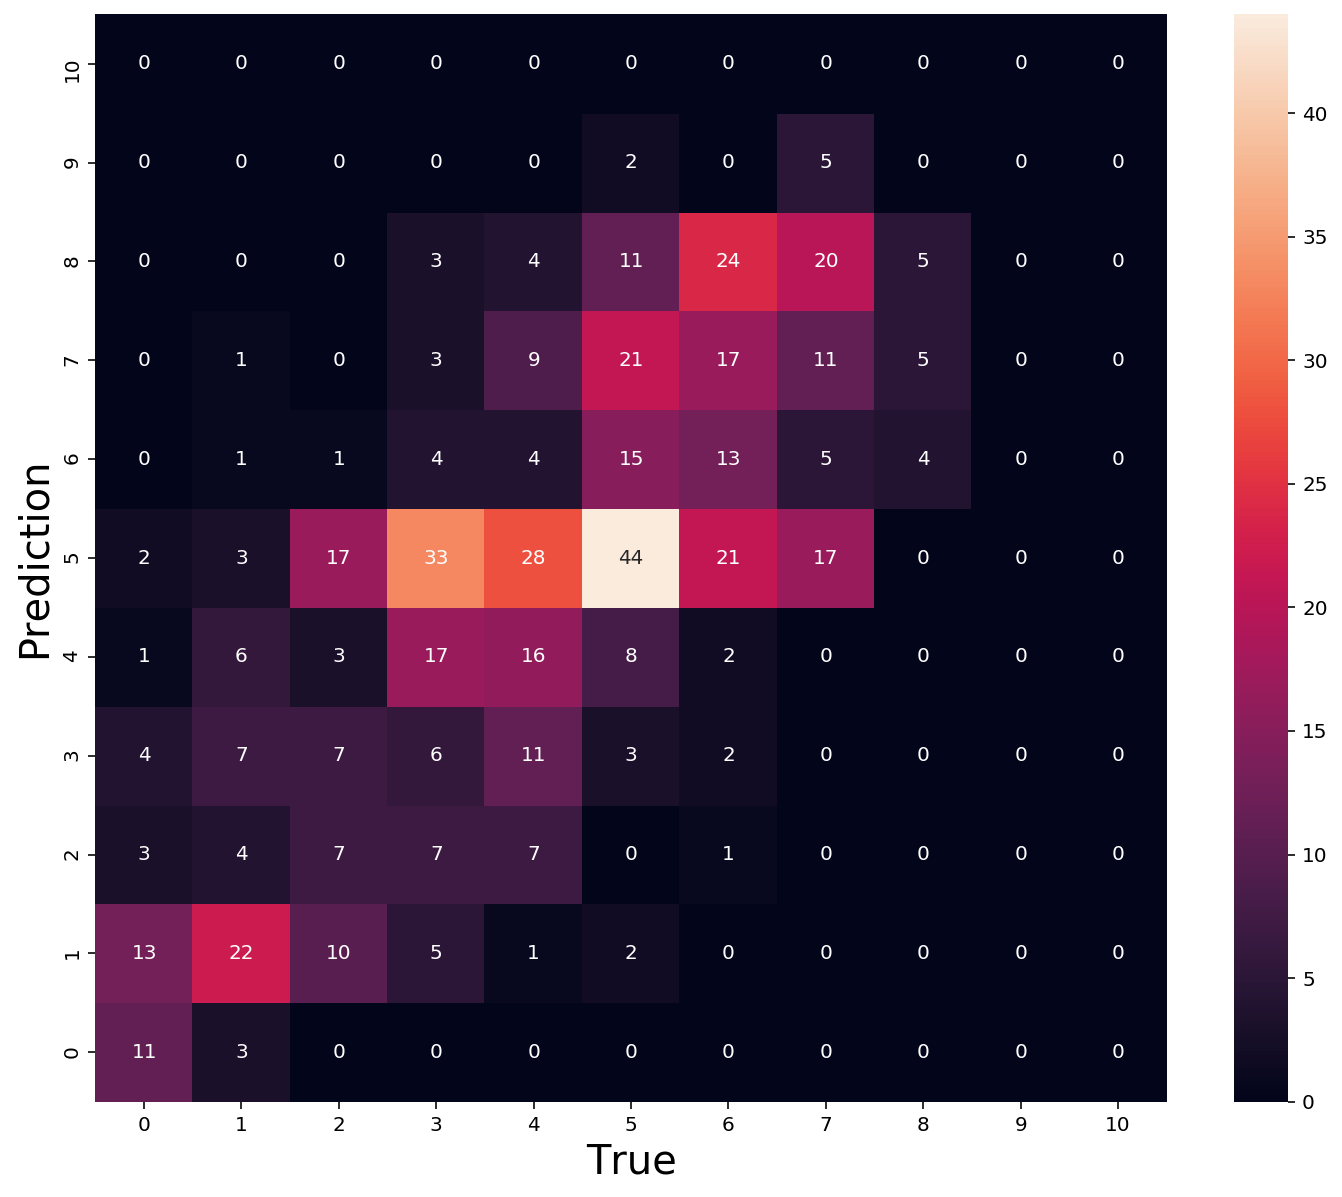

In [75]:
plt.figure(figsize=(12, 10))
ax = sns.heatmap(test_heatmap_df,annot=True, fmt='d')
ax.invert_yaxis()
ax.set_xlabel('True',fontsize=20);
ax.set_ylabel('Prediction',fontsize=20);
plt.show()

array([[11.,  3.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [13., 22., 10.,  5.,  1.,  2.,  0.,  0.,  0.,  0.,  0.],
       [ 3.,  4.,  7.,  7.,  7.,  0.,  1.,  0.,  0.,  0.,  0.],
       [ 4.,  7.,  7.,  6., 11.,  3.,  2.,  0.,  0.,  0.,  0.],
       [ 1.,  6.,  3., 17., 16.,  8.,  2.,  0.,  0.,  0.,  0.],
       [ 2.,  3., 17., 33., 28., 44., 21., 17.,  0.,  0.,  0.],
       [ 0.,  1.,  1.,  4.,  4., 15., 13.,  5.,  4.,  0.,  0.],
       [ 0.,  1.,  0.,  3.,  9., 21., 17., 11.,  5.,  0.,  0.],
       [ 0.,  0.,  0.,  3.,  4., 11., 24., 20.,  5.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  2.,  0.,  5.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])